## Import data and packages

In [261]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
from typing import List
warnings.filterwarnings('ignore')

In [262]:
# for google colab
# !wget -q 'https://raw.githubusercontent.com/Chelovek2002/pechenye-Yubileynoye/master/data/country_gdp_brand.csv'
# !wget -q 'https://raw.githubusercontent.com/Chelovek2002/pechenye-Yubileynoye/master/data/collage_words.csv'
# !wget -q 'https://raw.githubusercontent.com/Chelovek2002/pechenye-Yubileynoye/master/data/Categories.csv'

### Extracting car brands

In [263]:
def get_car_brands_list(path:str) -> List[str]:
    cats = pd.read_csv(path)

    # Pontiac is no longer exists as brand, so we don't need it
    # cats = cats[cats.Brand != 'Pontiac']

    catwise = cats.groupby(by=['Category'], as_index=True).agg(lambda x: ", ".join(x)).squeeze()
    car_brands = catwise['Cars'].split(", ")
    return car_brands

car_brands_list = get_car_brands_list('data/Categories.csv')
car_brands_list[:5]

['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac']

### Extracting associations with these brands

In [264]:
def get_words_df(path:str) -> pd.DataFrame:
    global car_brands_list

    words_df = pd.read_csv(path).dropna()

    # only car brands (Pontiac already excluded)
    words_df = words_df[words_df.Brand.isin(car_brands_list)]

    # initially data is divided by respondents/brand, so we aggregate by brand
    words_df = words_df.groupby(by=['Brand'], as_index=False).agg(lambda x: ", ".join(x))

    return words_df

words = get_words_df('data/collage_words.csv')
words.sample(5)

,Brand,Words
12,Hyundai,"road, mountain, nature, travel, landscape, no ..."
7,Dodge,"no person, agriculture, landscape, nature, cro..."
6,Chrysler,"flag, stripe, administration, patriotism, unit..."
22,Nissan,"no person, sky, travel, vehicle, transportatio..."
0,Acura,"science, flame, biology, cellular telephone, a..."


## LDA

#### Count occurrences of each word within each brand associations.

In [265]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10)
X = count_vectorizer.fit_transform(words["Words"].values)

#### Create 5 topics (components) and score similarity between each brand and each topic.
The resulting shape is (n_brands, n_components).

In [266]:
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1,random_state=101)
doc_topic = lda.fit_transform(X)

In [267]:
doc_topic.shape

(29, 5)

#### Find most relevant words for each brand.

In [268]:
topic_word = lda.components_  # score between each topic and each word
most_relevant_words = np.flip(np.argsort(topic_word, axis=1), axis=1)[:, :50] # indices

In [269]:
pd.DataFrame(topic_word, columns=count_vectorizer.get_feature_names_out())

,abandoned,abundance,accessory,accident,achievement,acoustic,active,actor,actress,administration,...,wet,wheat,white,wind,windshield,wing,wire,wooden,yacht,zoo
0,6.441167,0.315493,10.473571,0.202473,7.713317,2.132806,1.104358,10.401319,3.403383,1.623245,...,22.830852,5.355892,18.859313,13.481831,0.202137,6.875855,0.201120,6.268486,3.063054,19.225725
1,42.400248,0.202237,2.518188,17.204081,5.138101,6.839007,5.082900,17.971721,8.278148,43.846709,...,21.418987,15.284888,40.765019,45.467021,15.910047,16.888502,12.500194,40.495891,0.204642,13.998101
2,12.174732,0.213777,0.209559,1.104354,5.686285,1.098197,5.900052,0.203163,0.226593,0.204639,...,19.402469,0.203944,3.669307,0.225378,0.203720,5.329832,5.372185,4.984131,3.933179,0.563455
3,4.780111,5.543103,0.201216,1.150511,10.711096,0.202203,0.200667,1.907898,1.045808,22.481709,...,1.993641,1.953099,11.921473,8.874755,1.940160,0.903012,0.200001,3.331677,0.200605,0.200338
4,0.203742,35.725390,2.597467,1.338581,61.751200,3.727787,5.712023,18.515899,5.046068,19.843697,...,14.354051,0.202176,12.784888,3.951015,1.743936,9.002800,2.726500,5.919814,18.598520,5.012381


In [270]:
count_vectorizer.get_feature_names_out()[most_relevant_words]

array([['luxury', 'room', 'gold', 'insubstantial', 'round', 'elegant',
        'hotel', 'decoration', 'storm', 'energy', 'illuminated',
        'skyline', 'skyscraper', 'highway', 'graphic', 'items', 'still',
        'life', 'shining', 'furniture', 'speed', 'traditional', 'chair',
        'shape', 'out', 'ancient', 'wallpaper', 'clock', 'time', 'long',
        'inside', 'futuristic', 'instrument', 'wet', 'nude', 'boat',
        'landmark', 'danger', 'erotic', 'line', 'and', 'lingerie',
        'shadow', 'bus', 'studio', 'table', 'flash', 'sight', 'church',
        'museum'],
       ['rural', 'countryside', 'farm', 'fog', 'country', 'mammal',
        'environment', 'boy', 'agriculture', 'togetherness', 'happiness',
        'flora', 'highway', 'war', 'little', 'asphalt', 'power', 'soil',
        'athlete', 'iron', 'together', 'adolescent', 'hill',
        'automotive', 'construction', 'room', 'enjoyment', 'baby',
        'energy', 'veil', 'cloud', 'machine', 'safety', 'bird',
        'pa

### Visualize top 50 words

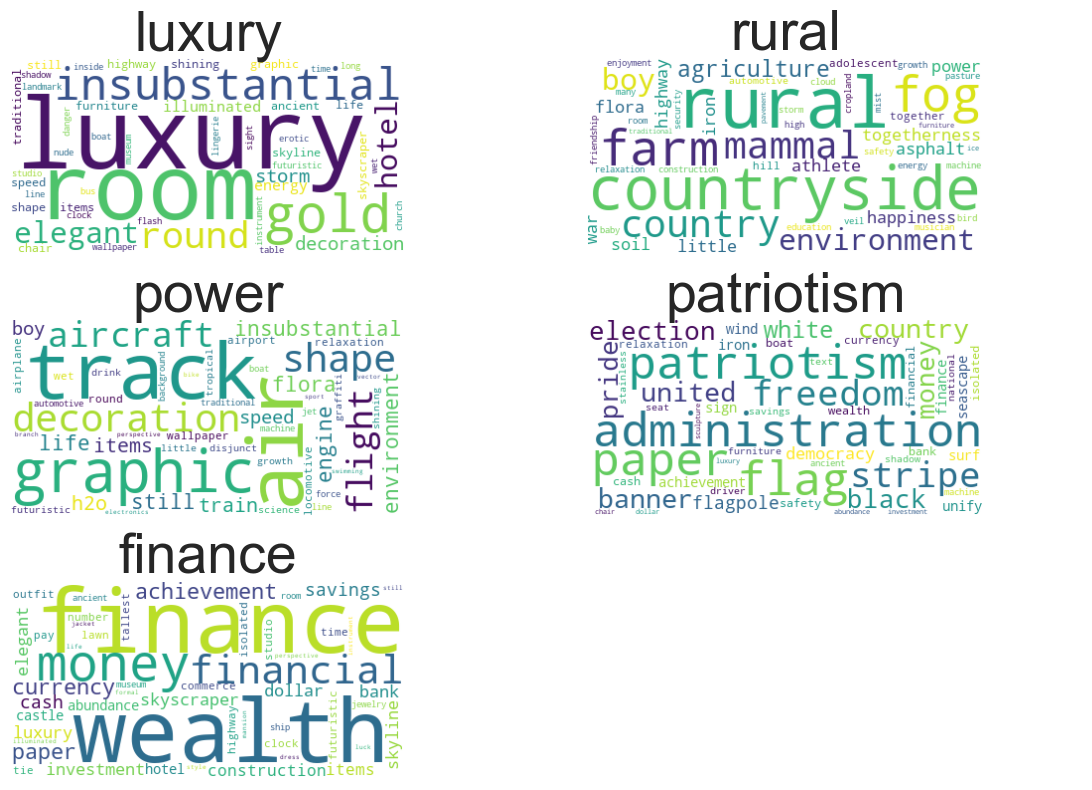

In [271]:
topic_labels = ['luxury', 'rural', 'power', 'patriotism', 'finance']
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

most_relevant_topic_words=[]
for i, ax in enumerate(axs.flat[:-1]):
    words_list = count_vectorizer.get_feature_names_out()[most_relevant_words[i]]
    most_relevant_topic_words.append([i, words_list])
    cloud = WordCloud(background_color='white').generate(' '.join(words_list))
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(topic_labels[i], fontsize=40)
    ax.axis('off')

axs.flat[-1].axis('off')
plt.tight_layout()
plt.show()

Now let's look at the most popular words for different car brands

In [272]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05)
tf_idf = np.array(vectorizer.fit_transform(words["Words"].values).todense())
ids = np.flip(tf_idf.argsort(axis=1), axis=1)

In [273]:
TD_IDF=pd.DataFrame(tf_idf, index=words['Brand'], columns=vectorizer.get_feature_names_out())
TD_IDF.head()

,abandoned,abbey,abdomen,abdominal,abundance,access,accessory,accident,accomplishment,accuracy,...,written,yacht,yard,yarn,youth,zebra,zen,zoo,zoology,zoom
Brand,,,,,,,,,,,,,,,,,,,,,
Acura,0.028877,0.0,0.029768,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.020102,0.000000,0.0,0.000000,0.07535,0.0,0.116328,0.000000,0.023940
Audi,0.024147,0.0,0.000000,0.0,0.015535,0.000000,0.018280,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.013896,0.000000,0.020019
BMW,0.000000,0.0,0.000000,0.0,0.071042,0.000000,0.000000,0.000000,0.0,0.081022,...,0.026303,0.030747,0.060767,0.0,0.020256,0.00000,0.0,0.000000,0.042841,0.018309
Buick,0.046960,0.0,0.000000,0.0,0.000000,0.025895,0.053323,0.017032,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.043071,0.00000,0.0,0.013512,0.000000,0.000000
Cadillac,0.029233,0.0,0.000000,0.0,0.037615,0.000000,0.022130,0.021205,0.0,0.000000,...,0.034817,0.020349,0.026812,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000


In [274]:
most_relevant_brand_words = [
    (brand, vectorizer.get_feature_names_out()[ids[i, :50]])  # ids[i,:50] is indices of top 50 words for i-th brand
    for i, brand in enumerate(car_brands_list)
]

In [275]:
# fig, axs = plt.subplots(4, 7, figsize=(12, 7), constrained_layout=True)

# for brand, words, ax in zip(cat, np.array(most_relevant_brand_words, dtype='object')[:, 1], axs.flat):
#     cloud = WordCloud(background_color='white', max_words=15).generate(' '.join(words))
#     ax.imshow(cloud)
#     ax.set_title(brand, fontsize=18)
#     ax.axis('off')

# plt.show()

As we can see, some of these make no sense for us. Let's then create a score that says how similar a brand to a topic

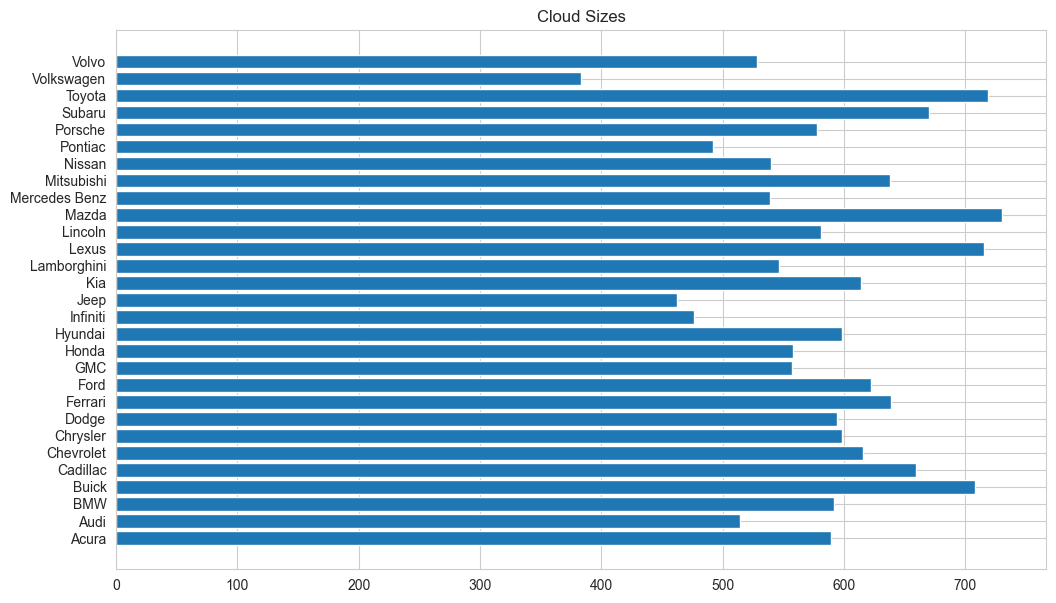

In [276]:
cloud_sizes = np.count_nonzero(tf_idf, axis=1)

plt.figure(figsize=(12, 7))
plt.barh(range(len(car_brands_list)), cloud_sizes)
plt.yticks(range(len(car_brands_list)), car_brands_list)
plt.title('Cloud Sizes')
plt.show()

That's lenghts of clouds. So 50 is at most 10% in one case almost 20%. Is it too much? Idk

In [277]:
pd.DataFrame(most_relevant_brand_words).sample(5)

,0,1
26,Toyota,"[power, rural, flora, track, automotive, sport..."
7,Dodge,"[rural, countryside, farm, country, agricultur..."
21,Mitsubishi,"[round, swimming, bamboo, pool, items, underwa..."
24,Porsche,"[investment, finance, savings, cash, dollar, f..."
5,Chevrolet,"[flora, rural, boy, farm, growth, country, dee..."


In [278]:
pd.DataFrame(most_relevant_topic_words)

,0,1
0,0,"[luxury, room, gold, insubstantial, round, ele..."
1,1,"[rural, countryside, farm, fog, country, mamma..."
2,2,"[air, track, graphic, decoration, shape, aircr..."
3,3,"[administration, flag, patriotism, paper, free..."
4,4,"[finance, wealth, money, financial, achievemen..."


In [279]:
# jaccard
def jaccard(wordset_1, wordset_2):
    intersection = set(wordset_1).intersection(set(wordset_2))
    union = set(wordset_1).union(set(wordset_2))
    return len(intersection) / len(union)


score_jaccard = [
    jaccard(bw, tw)
    for bw in np.array(most_relevant_brand_words,dtype='object')[:, 1]
    for tw in np.array(most_relevant_topic_words, dtype='object')[:, 1]
    ]
score_jaccard = np.array(score_jaccard).reshape(-1, 5)

score = pd.DataFrame(score_jaccard, columns=["luxury", "rural", "power", "patriotism", "finance"], index=car_brands_list)
score_cleaned = score.apply(lambda x: np.where(x > 0.1, x, 0))

# Датасет с продажами

In [280]:
cars_sales = pd.read_csv('data/country_gdp_brand.csv')
cars_sales.sample(10)

,country,gdp_per_capita,brand,cars_sold,country_total,share
825,Switzerland,87980,Volkswagen,40304,339736,0.118633
296,Germany,42973,BMW,264153,3761207,0.070231
425,Japan,36117,Dodge,399,5256140,0.000076
258,Estonia,19677,Volkswagen,1891,25983,0.072778
568,New Zealand,40365,Nissan,8339,160286,0.052026
941,Vietnam,3062,Mazda,32728,270509,0.120987
754,South Africa,6199,Hyundai,35858,545883,0.065688
184,Croatia,13519,Audi,2116,59607,0.035499
888,UK,47231,Subaru,3141,2731734,0.001150
48,Austria,46188,Nissan,7008,383749,0.018262


In [281]:
cars_sales.describe()

,gdp_per_capita,cars_sold,country_total,share
count,945.000000,9.450000e+02,9.450000e+02,945.000000
mean,30524.719577,6.011895e+04,1.950068e+06,0.036626
std,24004.777310,2.180533e+05,4.846925e+06,0.048657
min,1459.000000,1.030000e+02,1.704700e+04,0.000068
25%,10714.000000,1.471000e+03,1.527060e+05,0.005073
50%,23476.000000,6.512000e+03,4.146590e+05,0.019194
75%,45628.000000,2.861000e+04,1.800511e+06,0.048391
max,107201.000000,3.129744e+06,2.807532e+07,0.389574


In [282]:
cars_sales[cars_sales.country=='Korea'].sample(5)

,country,gdp_per_capita,brand,cars_sold,country_total,share
473,Korea,31053,Volkswagen,15390,1812994,0.008489
472,Korea,31053,Toyota,16774,1812994,0.009252
457,Korea,31053,Audi,12450,1812994,0.006867
469,Korea,31053,Mercedes Benz,70798,1812994,0.039050
463,Korea,31053,Hyundai,659755,1812994,0.363904


### Regression

In [283]:
data = pd.get_dummies(cars_sales, columns = ['country'], drop_first = True)

In [284]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
topic_lables = ['luxury', 'rural', 'power', 'patriotism', 'finance']

In [285]:
def regr_share_on_topics(score):
    df = data.merge(score_cleaned, left_on = 'brand', right_index=True)
    
    X = df.drop([ 'country_total','share','brand', 'cars_sold', 'gdp_per_capita'], axis = 1)
    y = df['share']

    #регрессия продаж отдельного бренда на скоры топиков (дробные)
    results = sm.OLS(y, sm.add_constant(X)).fit(cov_type = "HC0")
    print(results.summary())

In [286]:
regr_share_on_topics(score_cleaned)

                            OLS Regression Results                            
Dep. Variable:                  share   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.421
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           1.48e-46
Time:                        20:55:20   Log-Likelihood:                 1619.3
No. Observations:                 945   AIC:                            -3117.
Df Residuals:                     884   BIC:                            -2821.
Df Model:                          60                                         
Covariance Type:                  HC0                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [287]:
regressors = ['luxury','rural','power','patriotism','finance']
def regr_share_on_topics_by_country(score, country='France'):
    print(country.upper())
    country_sales = cars_sales[cars_sales['country'] == country]
    df = country_sales.merge(score, left_on='brand', right_index=True)
    X = df.drop([ 'country_total','share','brand', 'cars_sold', 'country','gdp_per_capita'], axis = 1)
    y = df['share']

    #регрессия продаж всех машин в отдельной стране на скоры топиков (дробные)
    results = sm.OLS(df['share'], sm.add_constant(df[regressors])).fit(cov_type = "HC0")
    
    print(results.summary().tables[1])
    print()

In [288]:
for country in cars_sales.country.unique():
  regr_share_on_topics_by_country(score_cleaned, country)

ARGENTINA
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0592      0.036      1.664      0.096      -0.011       0.129
luxury        -0.2740      0.117     -2.341      0.019      -0.503      -0.045
rural          0.0184      0.162      0.113      0.910      -0.300       0.336
power         -0.0828      0.119     -0.697      0.486      -0.316       0.150
patriotism     0.0483      0.141      0.342      0.733      -0.229       0.326
finance       -0.2104      0.048     -4.354      0.000      -0.305      -0.116

AUSTRALIA
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0136      0.022      0.604      0.546      -0.030       0.058
luxury        -0.0892      0.064     -1.395      0.163      -0.215       0.036
rural          0.1892      0.17

C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0295      0.027      1.109      0.267      -0.023       0.082
luxury        -0.1162      0.110     -1.054      0.292      -0.332       0.100
rural          0.0839      0.182      0.462      0.644      -0.272       0.440
power          0.1017      0.094      1.079      0.280      -0.083       0.287
patriotism     0.1609      0.106      1.522      0.128      -0.046       0.368
finance       -0.0920      0.036     -2.547      0.011      -0.163      -0.021

HUNGARY
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0754      0.025      3.045      0.002       0.027       0.124
luxury        -0.2286      0.079     -2.908      0.004      -0.383      -0.075
rural         -0.0700      0.080     -0.876

C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 obser

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0346      0.020      1.722      0.085      -0.005       0.074
luxury        -0.0827      0.070     -1.185      0.236      -0.219       0.054
rural          0.0050      0.063      0.079      0.937      -0.118       0.128
power         -0.0437      0.056     -0.785      0.433      -0.153       0.065
patriotism     0.2763      0.129      2.138      0.033       0.023       0.530
finance       -0.2076      0.041     -5.066      0.000      -0.288      -0.127

RUSSIA
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.018      0.936      0.349      -0.018       0.052
luxury        -0.1142      0.069     -1.653      0.098      -0.249       0.021
rural          0.0610      0.102      0.598 

C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\Tagir\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full 

In [289]:
def get_coefs(score):
    coefs=[]
    topics = ["luxury", "rural","power", "patriotism", "finance"]
    countries = cars_sales.country.unique()

    for country in countries:
        country_sales = cars_sales[cars_sales['country'] == country]
        country_for_regr = country_sales.merge(score, left_on = 'brand', right_index=True)
        X = country_for_regr.drop(['country_total','share','brand', 'cars_sold', 'country'], axis = 1)
        y = country_for_regr['share']
        results = sm.OLS(y, sm.add_constant(X)).fit(cov_type = "HC0")

        pvalue=results.pvalues.to_numpy()[1:6]
        pvalue=np.where(pvalue<=0.05, 1, 0)

        coefs.append(results.params.to_numpy()[1:6]*pvalue)
    
    coefs=pd.DataFrame(coefs, columns=topics, index=countries)
    return coefs

In [290]:
get_coefs(score_cleaned)

,luxury,rural,power,patriotism,finance
Argentina,-0.273996,0.000000,-0.000000,0.000000,-0.210399
Australia,-0.000000,0.000000,0.255610,-0.000000,-0.000000
Austria,-0.000000,-0.000000,-0.000000,0.000000,-0.248158
Belgium,-0.000000,-0.000000,-0.000000,0.384369,-0.257351
Brazil,-0.000000,0.000000,-0.000000,-0.000000,-0.107263
Bulgaria,-0.171059,-0.000000,-0.000000,-0.221695,0.000000
Canada,-0.183377,-0.000000,0.000000,-0.061091,-0.000000
Chile,-0.000000,0.000000,0.152070,0.000000,-0.000000
China,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
Colombia,-0.000000,0.000000,0.145082,0.000000,-0.079534


In [291]:
def regr_coef_on_gdp(score):
    y = get_coefs(score)
    X = cars_sales.loc[:, ['country','gdp_per_capita']].drop_duplicates().set_index('country')
    #регрессия продаж отдельного бренда на скоры топиков (дробные)
    for i in range(5):
        results = sm.OLS(y.iloc[:,i], sm.add_constant(X)).fit(cov_type = "HC0")
        print(y.columns[i].upper())
        print(results.summary().tables[1])

In [292]:
regr_coef_on_gdp(score_cleaned)

LUXURY
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0864      0.031     -2.760      0.006      -0.148      -0.025
gdp_per_capita -4.562e-08   7.67e-07     -0.059      0.953   -1.55e-06    1.46e-06
RURAL
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0294      0.016      1.802      0.072      -0.003       0.061
gdp_per_capita -1.114e-06   4.02e-07     -2.768      0.006    -1.9e-06   -3.25e-07
POWER
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0526      0.020      2.628      0.009       0.013       0.092
gdp_per_capita -3.365e-07   5.67e-07     -0.594      0.553   -1.45e-

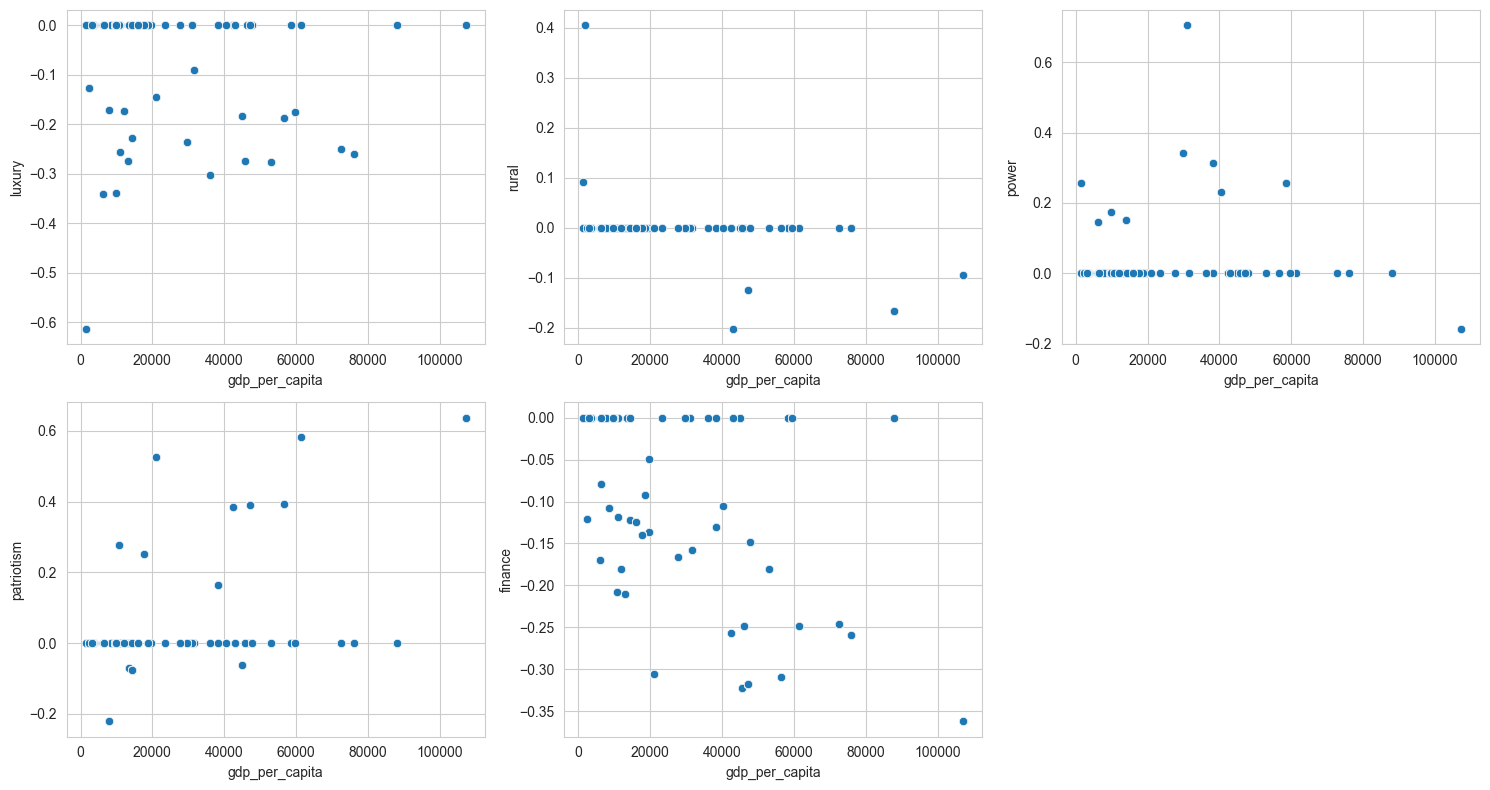

In [293]:
import seaborn as sns

topic_labels = ['luxury', 'rural', 'power', 'patriotism', 'finance']
def plot_coefs(score, lims='auto'):
    coefs = get_coefs(score)
    df = cars_sales.merge(coefs, left_on='country', right_index=True)

    if lims is 'auto':
        llim, hlim = coefs.to_numpy().min()*1.25, coefs.to_numpy().max()*1.25
    elif lims is None:
        llim = hlim = None
    else:
        llim, hlim = lims

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    for topic, ax in zip(topic_labels, axs.flat):
        sns.scatterplot(data=df, x='gdp_per_capita', y=topic, ax=ax).set(ylim=(llim,hlim))

    axs.flat[-1].axis('off')
    plt.tight_layout()
    plt.show()

plot_coefs(score_cleaned, None)

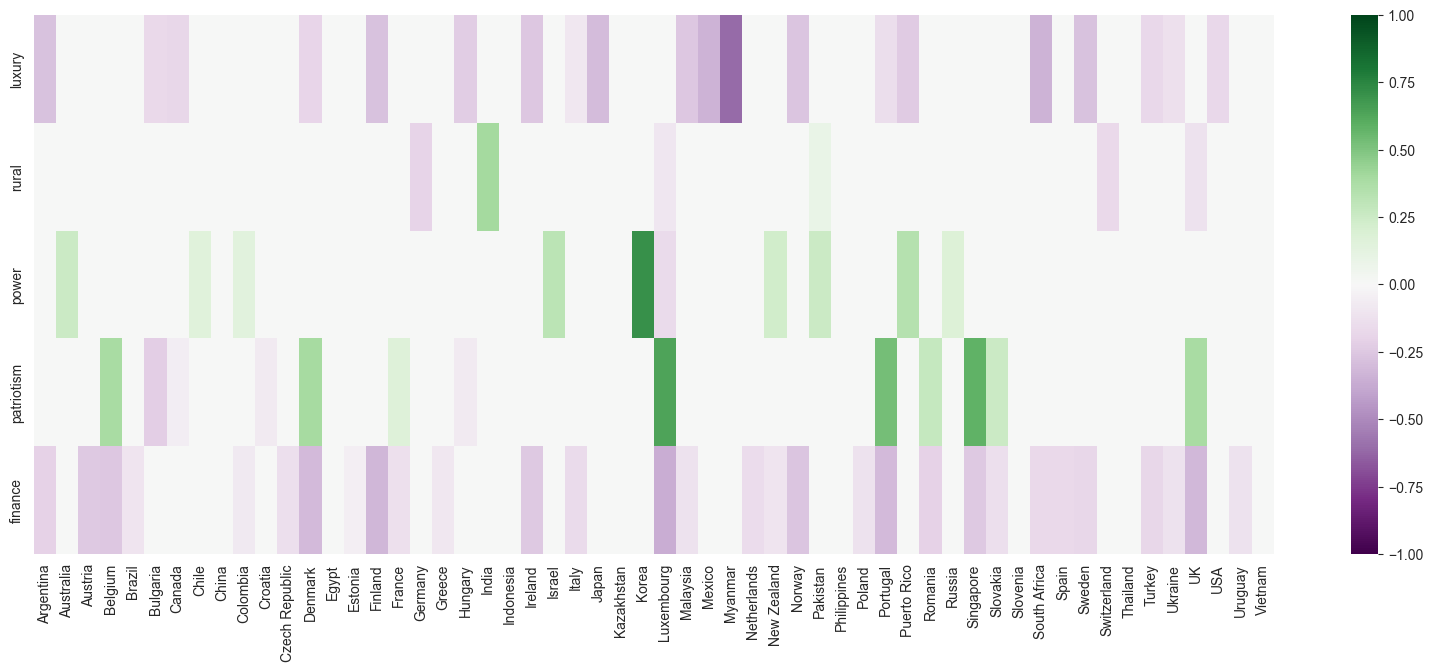

In [294]:
def plot_heatmap(score):
    coefs = get_coefs(score)
    figure = plt.figure(figsize=(20,7))
    sns.heatmap(coefs.T,cmap='PRGn', center=0, vmin=-1, vmax=1)
    plt.show()

plot_heatmap(score_cleaned)